develop the add existing base years per grade

In [2]:
%load_ext autoreload
%autoreload 2
%precision %e

'%e'

In [1]:
# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython, os

working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

os.chdir(scripts_dir)


In [5]:
import logging
import pypsa
import os.path
from _helpers import mock_snakemake
from _pypsa_helpers import shift_profile_to_planning_year

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [ ]:
target = os.path.join(root_dir, "resources/derived_data/cutout_China-2020c/solar_regions_by_class_min_cf_delta0.02_n2.geojson")
spv = gpd.read_file(target)
wind = gpd.read_file(os.path.join(root_dir, "resources/derived_data/cutout_China-2020c/onwind_regions_by_class_min_cf_delta0.07_n3.geojson"))


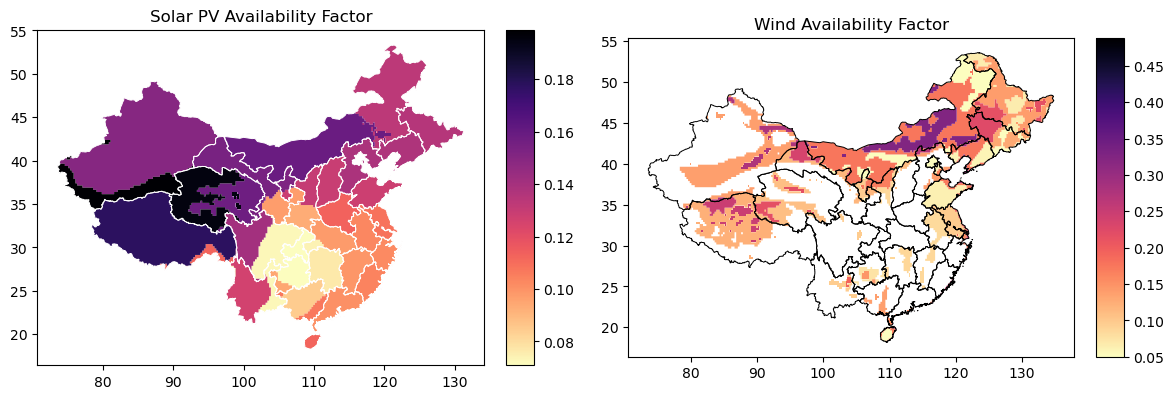

In [97]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2,figsize=(12, 5))
# Adjust colorbar to fit the subplot height

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=-0.3)
spv.plot("cf", cmap="magma_r", legend=True, edgecolor=None, linewidth=2, ax=ax[0], cax=cax)
spv.dissolve("bus").boundary.plot(edgecolor="white", facecolor="none", linewidth=0.7, ax=ax[0])
ax[0].set_title("Solar PV Availability Factor")

divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=-0.3)

wind[wind.cf>0.02].plot(
    "cf",
    cmap="magma_r",
    legend=True,
    edgecolor=None,
    linewidth=2,
    ax=ax[1],
    cax=cax2,
    vmin=0.05,
    missing_kwds={"color": "white"}
)
wind.dissolve("bus").boundary.plot(edgecolor="black", facecolor="none", linewidth=0.7, ax=ax[1])
ax[1].set_title("Wind Availability Factor")
fig.tight_layout()

In [24]:
if "snakemake" not in globals():
    snakemake = mock_snakemake(
        "add_existing_baseyear",
        topology="current+FCG",
        snakefile_path=os.path.abspath("../"),
        co2_pathway="remind_ssp2NPI",
        planning_horizons="2025",
        heating_demand="positive",
    )

In [25]:
import numpy as np
from add_electricity import load_costs

In [26]:
from add_existing_baseyear import read_existing_capacities, fix_existing_capacities, assign_year_bins
from add_existing_baseyear import add_power_capacities_installed_before_baseyear, add_existing_vre_capacities

In [27]:
tech_costs = snakemake.input.tech_costs
config = snakemake.config
baseyear = snakemake.params["baseyear"]
cost_year = snakemake.wildcards["planning_horizons"]

n = pypsa.Network(snakemake.input.network)
n_years = n.snapshot_weightings.generators.sum() / 8760

data_paths = {k: v for k, v in snakemake.input.items()}
costs = load_costs(tech_costs, config["costs"], config["electricity"], cost_year, n_years)


/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/home/ivanra/miniconda3/envs/pypsa-china/li

In [28]:
baseyear = snakemake.params["baseyear"]
# add_build_year_to_new_assets(n, baseyear)
if snakemake.params["add_baseyear_to_assets"]:
    add_build_year_to_new_assets(n, baseyear)

config = snakemake.config
tech_costs = snakemake.input.tech_costs
cost_year = snakemake.wildcards["planning_horizons"]
data_paths = {k: v for k, v in snakemake.input.items()}
vre_techs = ["solar", "onwind", "offwind"]

costs = load_costs(tech_costs, config["costs"], config["electricity"], cost_year, n_years)

existing_capacities = read_existing_capacities(data_paths)
year_bins = config["existing_capacities"]["grouping_years"]
# TODO add renewables
existing_capacities = assign_year_bins(existing_capacities, year_bins)
df = fix_existing_capacities(existing_capacities, costs, year_bins, baseyear)

vre_caps = df.query("Tech in @vre_techs | Fueltype in @vre_techs")
# vre_caps.loc[:, "Country"] = coco.CountryConverter().convert(["China"], to="iso2")
vres = add_existing_vre_capacities(n, costs, vre_caps, config)
df = pd.concat([df.query("Tech not in @vre_techs & Fueltype not in @vre_techs"), vres], axis=0)


In [30]:
df.resource_class.fillna("none", inplace=True)
df.pivot_table(
        index=["grouping_year", "Fueltype", "resource_class"],
        columns="bus",
        values="Capacity",
        aggfunc="sum",
    )
stored = df.copy

In [ ]:
stored.renamed)

<bound method NDFrame.copy of                                       Fueltype  Tech  Capacity  DateIn  \
Anhui-coal-1985               coal power plant  coal     320.0    1985   
Heilongjiang-coal-1985        coal power plant  coal     600.0    1985   
Henan-coal-1985               coal power plant  coal     320.0    1985   
InnerMongolia-coal-1985       coal power plant  coal    1000.0    1985   
Liaoning-coal-1985            coal power plant  coal     200.0    1985   
...                                        ...   ...       ...     ...   
Hebei grade2 offwind-2020              offwind   NaN     300.0    2020   
Jiangsu grade2 offwind-2020            offwind   NaN    4773.0    2020   
Liaoning grade2 offwind-2020           offwind   NaN     299.0    2020   
Shanghai grade2 offwind-2020           offwind   NaN     207.0    2020   
Zhejiang grade2 offwind-2020           offwind   NaN     486.0    2020   

                                cluster_bus  grouping_year  DateOut  lifetime  \


In [34]:
capacity.index.values

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hubei', 'Hunan', 'InnerMongolia', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang'], dtype=object)

In [ ]:
carrier = {
    "coal": "coal power plant",
    "CHP coal": "CHP coal",
    "CHP gas": "CHP gas",
    "OCGT": "OCGT gas",
    "solar": "solar",
    "solar thermal": "solar thermal",
    "onwind": "onwind",
    "offwind": "offwind",
    "coal boiler": "coal boiler",
    "ground heat pump": "heat pump",
    "nuclear": "nuclear",
}

# in case user forgot to do it
df = fix_existing_capacities(
    df, costs, config["existing_capacities"]["grouping_years"], baseyear
)
df.resource_class.fillna("none", inplace=True)
df = df.pivot_table(
    index=["grouping_year", "Fueltype", "resource_class"],
    columns="bus",
    values="Capacity",
    aggfunc="sum",
)
# TODO do we really need to loop over the years?
for grouping_year, generator, resouce_class in df.index:
    print(generator, grouping_year)
    # capacity is the capacity in MW at each node for this
    capacity = df.loc[grouping_year, generator]
    capacity = capacity[~capacity.isna()]
    capacity = capacity[capacity > config["existing_capacities"]["threshold_capacity"]].T
    capacity.fillna(0, inplace=True)
    if capacity.values.max() == 0:
        continue
    
    vre_carriers = ["solar", "onwind", "offwind"]
    if generator in vre_carriers:
        mask = n.generators_t.p_max_pu.columns.map(n.generators.carrier) == generator
        p_max_pu = n.generators_t.p_max_pu.loc[:, mask]
        n.add(
            "Generator",
            capacity.index,
            suffix=" " + generator + "-" + str(grouping_year),
            bus=capacity.index.values,
            carrier=carrier[generator],
            p_nom=capacity,
            p_nom_min=capacity,
            p_nom_extendable=False,
            marginal_cost=costs.at[generator, "marginal_cost"],
            capital_cost=costs.at[generator, "capital_cost"],
            efficiency=costs.at[generator, "efficiency"],
            p_max_pu=p_max_pu.rename(columns=n.generators.bus),
            build_year=grouping_year,
            lifetime=costs.at[generator, "lifetime"],
        )

    if generator == "coal":
        n.add(
            "Generator",
            capacity.index,
            suffix=" " + generator + "-" + str(grouping_year),
            bus=capacity.index.values,
            carrier=carrier[generator],
            p_nom=capacity,
            p_nom_extendable=False,
            marginal_cost=costs.at[generator, "marginal_cost"],
            capital_cost=costs.at[generator, "capital_cost"],
            efficiency=costs.at[generator, "efficiency"],
            build_year=grouping_year,
            lifetime=costs.at[generator, "lifetime"],
        )

    if generator == "nuclear":
        n.add(
            "Generator",
            capacity.index,
            suffix=" " + generator + "-" + str(grouping_year),
            bus=capacity.index.values,
            carrier=carrier[generator],
            p_nom=capacity,
            p_nom_min=capacity,
            p_nom_extendable=False,
            p_min_pu=0.7,
            marginal_cost=costs.at[generator, "marginal_cost"],
            capital_cost=costs.at[generator, "capital_cost"],
            efficiency=costs.at[generator, "efficiency"],
            build_year=grouping_year,
            lifetime=costs.at[generator, "lifetime"],
        )

    if generator == "solar thermal" and config["heat_coupling"]:
        p_max_pu = n.generators_t.p_max_pu[capacity.index + " central " + generator]
        p_max_pu.columns = capacity.index
        n.add(
            "Generator",
            capacity.index,
            suffix=" central " + generator + "-" + str(grouping_year),
            bus=capacity.index.values + " central heat",
            carrier=carrier[generator],
            p_nom=capacity,
            p_nom_min=capacity,
            p_nom_extendable=False,
            marginal_cost=costs.at["central " + generator, "marginal_cost"],
            capital_cost=costs.at["central " + generator, "capital_cost"],
            p_max_pu=p_max_pu,
            build_year=grouping_year,
            lifetime=costs.at["central " + generator, "lifetime"],
        )

    if generator == "CHP coal" and config["heat_coupling"]:
        bus0 = capacity.index + " coal"
        n.add(
            "Link",
            capacity.index,
            suffix=" " + generator + " generator" + "-" + str(grouping_year),
            bus0=bus0,
            bus1=capacity.index,
            carrier=carrier[generator],
            marginal_cost=0.37 * costs.at["central coal CHP", "VOM"],  # NB: VOM is per MWel
            capital_cost=0.37
            * costs.at["central coal CHP", "capital_cost"],  # NB: fixed cost is per MWel,
            p_nom=capacity / 0.37,
            p_nom_min=capacity / 0.37,
            p_nom_extendable=False,
            efficiency=0.37,
            p_nom_ratio=1.0,
            c_b=0.75,
            build_year=grouping_year,
            lifetime=costs.at["central coal CHP", "lifetime"],
        )

        n.add(
            "Link",
            capacity.index,
            suffix=" " + generator + " boiler" + "-" + str(grouping_year),
            bus0=bus0,
            bus1=capacity.index + " central heat",
            carrier=carrier[generator],
            marginal_cost=0.37 * costs.at["central coal CHP", "VOM"],  # NB: VOM is per MWel
            p_nom=capacity / 0.37 * 0.15,
            p_nom_min=capacity / 0.37 * 0.15,
            p_nom_extendable=False,
            efficiency=0.37 / 0.15,
            build_year=grouping_year,
            lifetime=costs.at["central coal CHP", "lifetime"],
        )

    if generator == "CHP gas" and config["heat_coupling"]:
        bus0 = capacity.index + " gas"
        n.add(
            "Link",
            capacity.index,
            suffix=" " + generator + " generator" + "-" + str(grouping_year),
            bus0=bus0,
            bus1=capacity.index,
            carrier=carrier[generator],
            marginal_cost=costs.at["central gas CHP", "efficiency"]
            * costs.at["central gas CHP", "VOM"],  # NB: VOM is per MWel
            capital_cost=costs.at["central gas CHP", "efficiency"]
            * costs.at["central gas CHP", "capital_cost"],  # NB: fixed cost is per MWel,
            p_nom=capacity / costs.at["central gas CHP", "efficiency"],
            p_nom_min=capacity / costs.at["central gas CHP", "efficiency"],
            p_nom_extendable=False,
            efficiency=costs.at["central gas CHP", "efficiency"],
            p_nom_ratio=1.0,
            c_b=costs.at["central gas CHP", "c_b"],
            build_year=grouping_year,
            lifetime=costs.at["central gas CHP", "lifetime"],
        )
        n.add(
            "Link",
            capacity.index,
            suffix=" " + generator + " boiler" + "-" + str(grouping_year),
            bus0=bus0,
            bus1=capacity.index + " central heat",
            carrier=carrier[generator],
            marginal_cost=costs.at["central gas CHP", "efficiency"]
            * costs.at["central gas CHP", "VOM"],  # NB: VOM is per MWel
            p_nom=capacity
            / costs.at["central gas CHP", "efficiency"]
            * costs.at["central gas CHP", "c_v"],
            p_nom_min=capacity
            / costs.at["central gas CHP", "efficiency"]
            * costs.at["central gas CHP", "c_v"],
            p_nom_extendable=False,
            efficiency=costs.at["central gas CHP", "efficiency"]
            / costs.at["central gas CHP", "c_v"],
            build_year=grouping_year,
            lifetime=costs.at["central gas CHP", "lifetime"],
        )

    if generator == "OCGT":
        bus0 = capacity.index + " gas"
        n.add(
            "Link",
            capacity.index,
            suffix=" " + generator + "-" + str(grouping_year),
            bus0=bus0,
            bus1=capacity.index,
            carrier=carrier[generator],
            marginal_cost=costs.at[generator, "efficiency"]
            * costs.at[generator, "VOM"],  # NB: VOM is per MWel
            capital_cost=costs.at[generator, "efficiency"]
            * costs.at[generator, "capital_cost"],
            # NB: fixed cost is per MWel
            p_nom=capacity / costs.at[generator, "efficiency"],
            p_nom_min=capacity / costs.at[generator, "efficiency"],
            p_nom_extendable=False,
            efficiency=costs.at[generator, "efficiency"],
            build_year=grouping_year,
            lifetime=costs.at[generator, "lifetime"],
        )

    if generator == "coal boiler" and config["heat_coupling"]:
        bus0 = capacity.index + " coal"
        for cat in [" central "]:
            n.add(
                "Link",
                capacity.index,
                suffix="" + cat + generator + "-" + str(grouping_year),
                bus0=bus0,
                bus1=capacity.index + cat + "heat",
                carrier=carrier[generator],
                marginal_cost=costs.at[cat.lstrip() + generator, "efficiency"]
                * costs.at[cat.lstrip() + generator, "VOM"],
                capital_cost=costs.at[cat.lstrip() + generator, "efficiency"]
                * costs.at[cat.lstrip() + generator, "capital_cost"],
                p_nom=capacity / costs.at[cat.lstrip() + generator, "efficiency"],
                p_nom_min=capacity / costs.at[cat.lstrip() + generator, "efficiency"],
                p_nom_extendable=False,
                efficiency=costs.at[cat.lstrip() + generator, "efficiency"],
                build_year=grouping_year,
                lifetime=costs.at[cat.lstrip() + generator, "lifetime"],
            )
    # TODO fix centralise
    if generator == "ground heat pump" and config["heat_coupling"]:
        date_range = pd.date_range(
            "2025-01-01 00:00",
            "2025-12-31 23:00",
            freq=config["snapshots"]["freq"],
            tz="Asia/shanghai",
        )
        date_range = date_range.map(lambda t: t.replace(year=2020))

        with pd.HDFStore(snakemake.input.cop_name, mode="r") as store:
            gshp_cop = store["gshp_cop_profiles"]
            gshp_cop.index = gshp_cop.index.tz_localize(None)
            gshp_cop = shift_profile_to_planning_year(
                gshp_cop, snakemake.wildcards.planning_horizons
            )
            gshp_cop = gshp_cop.loc[n.snapshots]
        n.add(
            "Link",
            capacity.index,
            suffix=" " + generator + "-" + str(grouping_year),
            bus0=capacity.index,
            bus1=capacity.index + " central heat",
            carrier="heat pump",
            efficiency=(
                gshp_cop[capacity.index]
                if config["time_dep_hp_cop"]
                else costs.at["decentral ground-sourced heat pump", "efficiency"]
            ),
            capital_cost=costs.at["decentral ground-sourced heat pump", "efficiency"]
            * costs.at["decentral ground-sourced heat pump", "capital_cost"],
            marginal_cost=costs.at["decentral ground-sourced heat pump", "efficiency"]
            * costs.at["decentral ground-sourced heat pump", "marginal_cost"],
            p_nom=capacity / costs.at["decentral ground-sourced heat pump", "efficiency"],
            p_nom_min=capacity / costs.at["decentral ground-sourced heat pump", "efficiency"],
            p_nom_extendable=False,
            build_year=grouping_year,
            lifetime=costs.at["decentral ground-sourced heat pump", "lifetime"],
        )

/tmp/ipykernel_740175/36991910.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hubei', 'Hunan', 'InnerMongolia', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai',
       'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang', 'Yunnan',
       'Zhejiang'],
      dtype='object', name='bus')` given for bus of Generator `Index(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
 

coal power plant 1985.0
coal power plant 1990.0
coal power plant 1995.0
CHP coal 1995.0
OCGT gas 1995.0
coal boiler 1995.0
coal power plant 2000.0
CHP coal 2000.0
OCGT gas 2000.0
coal boiler 2000.0
CHP gas 2000.0
coal power plant 2005.0
CHP coal 2005.0
OCGT gas 2005.0
coal boiler 2005.0
CHP gas 2005.0
heat pump 2005.0
coal power plant 2010.0
CHP coal 2010.0
OCGT gas 2010.0
coal boiler 2010.0
CHP gas 2010.0
heat pump 2010.0
coal power plant 2015.0
CHP coal 2015.0
OCGT gas 2015.0
coal boiler 2015.0
CHP gas 2015.0
heat pump 2015.0
coal power plant 2020.0
CHP coal 2020.0
OCGT gas 2020.0
coal boiler 2020.0
CHP gas 2020.0
heat pump 2020.0
nuclear 2020.0
solar thermal 2020.0


In [ ]:

        if generator == "nuclear":
            n.add(
                "Generator",
                capacity.index,
                suffix=" " + generator + "-" + str(grouping_year),
                bus=capacity.index,
                carrier=carrier[generator],
                p_nom=capacity,
                p_nom_min=capacity,
                p_nom_extendable=False,
                p_min_pu=0.7,
                marginal_cost=costs.at[generator, "marginal_cost"],
                capital_cost=costs.at[generator, "capital_cost"],
                efficiency=costs.at[generator, "efficiency"],
                build_year=grouping_year,
                lifetime=costs.at[generator, "lifetime"],
            )


In [32]:
n.generators

,bus,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,carrier,marginal_cost,lifetime,capital_cost,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Anhui grade0 onwind,Anhui,0.0,True,0.0,0.000000e+00,0.0,onwind,0.0,25.0,97132.064947,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Anhui grade1 onwind,Anhui,0.0,True,0.0,3.024979e+04,0.0,onwind,0.0,25.0,97132.064947,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Anhui grade2 onwind,Anhui,0.0,True,0.0,7.641835e+04,0.0,onwind,0.0,25.0,97132.064947,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Beijing grade0 onwind,Beijing,0.0,True,0.0,0.000000e+00,0.0,onwind,0.0,25.0,97132.064947,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Beijing grade1 onwind,Beijing,0.0,True,0.0,8.163303e+03,0.0,onwind,0.0,25.0,97132.064947,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tibet hydroelectricity,Tibet,2100.0,False,2100.0,inf,0.0,hydroelectricity,0.0,inf,0.000000,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Xinjiang hydroelectricity,Xinjiang,8000.0,False,8000.0,inf,0.0,hydroelectricity,0.0,inf,0.000000,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Yunnan hydroelectricity,Yunnan,50870.0,False,50870.0,inf,0.0,hydroelectricity,0.0,inf,0.000000,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [ ]:
out_ = add_power_capacities_installed_before_baseyear(n, costs, config, df)
out_


INFO:add_existing_baseyear:adding power capacities installed before baseyear


AttributeError: 'DataFrame' object has no attribute 'DateIn'

In [ ]:
grouping_year

2.020000e+03

In [ ]:
grouping_year

2.020000e+03

In [ ]:
out = n.generators.groupby(["carrier","bus"]).p_nom_min.sum().sort_values(ascending=False)

In [ ]:
out.loc[("coal", slice(None))]

bus
Chongqing        0.0
Beijing          0.0
Fujian           0.0
Gansu            0.0
Guangdong        0.0
Guangxi          0.0
Guizhou          0.0
Hainan           0.0
Hebei            0.0
Heilongjiang     0.0
Henan            0.0
Hubei            0.0
Hunan            0.0
InnerMongolia    0.0
Jiangsu          0.0
Jiangxi          0.0
Jilin            0.0
Liaoning         0.0
Ningxia          0.0
Qinghai          0.0
Shaanxi          0.0
Shandong         0.0
Shanghai         0.0
Shanxi           0.0
Sichuan          0.0
Tianjin          0.0
Tibet            0.0
Xinjiang         0.0
Yunnan           0.0
Zhejiang         0.0
Anhui            0.0
Name: p_nom_min, dtype: float64

In [ ]:

for grouping_year, generator, resource_class in df.index:
    # capacity is the capacity in MW at each node for this
    capacity = df.loc[grouping_year, generator, resource_class]
    capacity = capacity[~capacity.isna()]
    capacity = capacity[capacity > 1]
    suffix = "-ac" if generator == "offwind" else ""
    name_suffix = f" {generator}{suffix}-{grouping_year}"

In [ ]:
import xarray as xr
p = "/home/ivanra/documents/PyPSA-China-PIK/resources/derived_data/cutout_China-2020c/profile_onwind-min_cf_delta0.05_n3.nc"
with xr.open_dataset(p) as ds:
    if ds.indexes["bus"].empty:
        pass
    if "year" in ds.indexes:
        ds = ds.sel(year=ds.year.min(), drop=True)

In [ ]:
ds.p_nom_max

<xarray.DataArray 'p_nom_max' (bus: 31, bin: 3)> Size: 744B
[93 values with dtype=float64]
Coordinates:
  * bus      (bus) <U13 2kB 'Anhui' 'Beijing' ... 'Yunnan' 'Zhejiang'
  * bin      (bin) int64 24B 0 1 2

In [ ]:
import powerplantmatching as pm
renw = pm.data.IRENASTAT()
renw.query("Country == 'China' & Technology == 'Onshore' & Year == @renw.Year.max()")
renw.head(1)

,Country,Fueltype,Year,Technology,Grid,Capacity
0,Afghanistan,Biogas,2000,Biogas,Off-grid,0.0


In [ ]:
import country_converter as coco

In [ ]:
vre_techs = ['onwind',
 'offwind',
 'offwind-ac',
 'offwind-dc',
 'solar',]
vre_caps = existing_capacities.query("Tech in @vre_techs | Fueltype in @vre_techs")
vre_caps.loc[:, "Country"] = coco.CountryConverter().convert(["China"], to="iso2")


/tmp/ipykernel_667801/1644046175.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
irena = pm.data.IRENASTAT().powerplant.convert_country_to_alpha2()
irena

,Country,Fueltype,Year,Technology,Grid,Capacity
0,AF,Biogas,2000,Biogas,Off-grid,0.0
1,AF,Biogas,2000,Biogas,On-grid,0.0
2,AF,Biogas,2001,Biogas,Off-grid,0.0
3,AF,Biogas,2001,Biogas,On-grid,0.0
4,AF,Biogas,2002,Biogas,Off-grid,0.0
...,...,...,...,...,...,...
204283,ZW,Wind,2022,Onshore,On-grid,0.0
204284,ZW,Wind,2023,Offshore,Off-grid,0.0
204285,ZW,Wind,2023,Offshore,On-grid,0.0
204286,ZW,Wind,2023,Onshore,Off-grid,0.0


In [ ]:
from functions import cartesian
import re

In [ ]:
vre_caps.groupby("Tech").Capacity.sum().sort_values(ascending=False)

Tech
solar      253600.0
onwind     235224.2
offwind      7750.0
Name: Capacity, dtype: float64

In [ ]:
grouped = vre_caps.groupby(["Country", "cluster_bus", "Tech", "DateIn"]).Capacity.sum()
vre_caps.Country.unique()

array(['CN'], dtype=object)

In [ ]:
grouped.unstack().reset_index().query("Country == 'CN'").drop(columns=["Country"])

DateIn,cluster_bus,Tech,2000.0,2005.0,2010.0,2015.0,2020.0
0,Anhui,onwind,NaN,NaN,NaN,1488.0,2043.0
1,Anhui,solar,NaN,NaN,NaN,1208.0,12492.0
2,Beijing,onwind,NaN,NaN,136.0,50.0,NaN
3,Beijing,solar,NaN,NaN,NaN,76.0,544.0
4,Chongqing,onwind,NaN,NaN,49.0,246.0,528.0
...,...,...,...,...,...,...,...
64,Yunnan,onwind,NaN,NaN,194.0,4637.0,3657.0
65,Yunnan,solar,NaN,NaN,NaN,1174.0,2706.0
66,Zhejiang,offwind,NaN,NaN,NaN,NaN,486.0
67,Zhejiang,onwind,NaN,NaN,138.0,844.0,338.0


In [ ]:
grouped_vre = vre_caps.groupby(["Tech", "cluster_bus", "DateIn"]).Capacity.sum()
vre_df = grouped_vre.unstack().reset_index()

# Create a DataFrame with all combinations of cluster_bus and Tech
all_combinations = pd.MultiIndex.from_product(
    [vre_df['cluster_bus'].unique(), vre_df['Tech'].unique()],
    names=['cluster_bus', 'Tech']
).to_frame(index=False)

# Merge with the existing vre_df to fill missing combinations
vre_df = all_combinations.merge(vre_df, on=['cluster_bus', 'Tech'], how='left')

# Fill missing values with NaN or appropriate defaults
vre_df.fillna(0, inplace=True)

vre_df

,cluster_bus,Tech,2000.0,2005.0,2010.0,2015.0,2020.0
0,Fujian,offwind,0.0,0.0,0.0,0.0,627.0
1,Fujian,onwind,0.0,16.0,299.0,1176.0,2006.0
2,Fujian,solar,0.0,0.0,0.0,129.0,1891.0
3,Guangdong,offwind,0.0,0.0,0.0,0.0,600.0
4,Guangdong,onwind,0.0,100.0,517.2,1562.1,2528.0
...,...,...,...,...,...,...,...
88,Xinjiang,onwind,0.0,0.0,700.0,10905.0,9799.0
89,Xinjiang,solar,0.0,0.0,0.0,5287.0,7373.0
90,Yunnan,offwind,0.0,0.0,0.0,0.0,0.0
91,Yunnan,onwind,0.0,0.0,194.0,4637.0,3657.0


In [ ]:
df_agg.query(' bus in ["Fujian", "Jiangsu "] & Fueltype=="offwind"').Capacity.sum()

np.float64(627.0)

In [ ]:
existing_capacities.query(' cluster_bus in ["Fujian", "Jiangsu "] & Fueltype=="offwind" & DateIn==2020').Capacity.sum()

np.float64(627.0)

In [ ]:
tech_map = {"solar": "PV", "onwind": "Onshore", "offwind-ac": "Offshore", "offwind": "Offshore"}
tech_map = {k:tech_map[k] for k in tech_map if k in config["Techs"]["vre_techs"]}
df_vres= pd.DataFrame()

In [ ]:
for country, group in carrier_gens.groupby(
    carrier_gens.bus.map(n.buses.country)):
    break

In [ ]:
is_complete = set(carrier_gens.bus.values).difference(set(nodes))
is_complete

set()

In [ ]:
existing_capacities

,Fueltype,Tech,Capacity,DateIn,cluster_bus,DateOut
Anhui-coal-1985,coal power plant,coal,320.0,1985.0,Anhui,40.000000
Heilongjiang-coal-1985,coal power plant,coal,600.0,1985.0,Heilongjiang,40.000000
Henan-coal-1985,coal power plant,coal,320.0,1985.0,Henan,40.000000
InnerMongolia-coal-1985,coal power plant,coal,1000.0,1985.0,InnerMongolia,40.000000
Liaoning-coal-1985,coal power plant,coal,200.0,1985.0,Liaoning,40.000000
...,...,...,...,...,...,...
Hainan-nuclear-2020,nuclear,nuclear,1300.0,2020.0,Hainan,50.000001
Jiangsu-nuclear-2020,nuclear,nuclear,6608.0,2020.0,Jiangsu,50.000001
Liaoning-nuclear-2020,nuclear,nuclear,5594.0,2020.0,Liaoning,50.000001
Shandong-nuclear-2020,nuclear,nuclear,2717.0,2020.0,Shandong,50.000001


In [ ]:
sorted = df_agg.groupby(["Fueltype", "bus"]).Capacity.sum()
sorted

Fueltype  bus      
offwind   Fujian         627.0
          Guangdong      600.0
          Hebei          300.0
          Jiangsu       5012.0
          Liaoning       299.0
                        ...   
solar     Sichuan       1910.0
          Tibet         1370.0
          Xinjiang     12660.0
          Yunnan        3880.0
          Zhejiang     15170.0
Name: Capacity, Length: 65, dtype: float64

In [ ]:
existing_capacities.query("Fueltype in ['solar', 'offwind', 'onwind']").rename(columns={"cluster_bus": "bus"}).groupby(["Fueltype", "bus"]).Capacity.sum()

Fueltype  bus      
offwind   Fujian         627.0
          Guangdong      600.0
          Hebei          300.0
          Jiangsu       5012.0
          Liaoning       299.0
                        ...   
solar     Tianjin       1640.0
          Tibet         1370.0
          Xinjiang     12660.0
          Yunnan        3880.0
          Zhejiang     15170.0
Name: Capacity, Length: 69, dtype: float64

In [ ]:
df_agg.groupby("Fueltype").Capacity.sum().sort_values(ascending=False)

Fueltype
solar      211428.0
onwind     118172.9
offwind      7292.0
Name: Capacity, dtype: float64

In [ ]:
df_ = existing_capacities.groupby(["Fueltype", "DateIn"]).Capacity.sum().sort_values(ascending=False)
df_.loc[(slice(None), 2020)]

Fueltype
solar               211428.000000
coal power plant    146354.000000
onwind              118172.900000
CHP coal             65211.000000
coal boiler          55757.878333
nuclear              54647.000000
CHP gas              27602.120000
offwind               7292.000000
OCGT gas              2712.400000
heat pump             1809.760000
solar thermal          500.000000
Name: Capacity, dtype: float64

In [ ]:
df.query("Country == 'China'").T

Country,China
Year,
2000,0.0
2001,0.0
2002,0.0
2003,0.0
2004,0.0
2005,0.0
2006,0.0
2007,1.5
2008,0.0


In [ ]:
gen_i = n.generators.query("carrier == @carrier").index
carrier_gens = n.generators.loc[gen_i]

In [ ]:
carrier_gens

,bus,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,carrier,marginal_cost,lifetime,capital_cost,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Fujian grade0 offwind,Fujian,0.0,True,0.0,3296.044855,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Fujian grade1 offwind,Fujian,0.0,True,0.0,13220.392343,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Fujian grade2 offwind,Fujian,0.0,True,0.0,63802.530694,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Guangdong grade0 offwind,Guangdong,0.0,True,0.0,11957.573073,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Guangdong grade1 offwind,Guangdong,0.0,True,0.0,53450.954782,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Guangdong grade2 offwind,Guangdong,0.0,True,0.0,84562.326131,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Guangxi grade0 offwind,Guangxi,0.0,True,0.0,3428.856850,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Guangxi grade1 offwind,Guangxi,0.0,True,0.0,16187.535259,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Guangxi grade2 offwind,Guangxi,0.0,True,0.0,17021.295022,0.0,offwind,0.0,25.0,375904.654226,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [ ]:

existing_capacities

,Fueltype,Tech,Capacity,DateIn,cluster_bus
Anhui-coal-1985,coal power plant,coal,320.0,1985.0,Anhui
Heilongjiang-coal-1985,coal power plant,coal,600.0,1985.0,Heilongjiang
Henan-coal-1985,coal power plant,coal,320.0,1985.0,Henan
InnerMongolia-coal-1985,coal power plant,coal,1000.0,1985.0,InnerMongolia
Liaoning-coal-1985,coal power plant,coal,200.0,1985.0,Liaoning
...,...,...,...,...,...
Hainan-nuclear-2020,nuclear,nuclear,1300.0,2020.0,Hainan
Jiangsu-nuclear-2020,nuclear,nuclear,6608.0,2020.0,Jiangsu
Liaoning-nuclear-2020,nuclear,nuclear,5594.0,2020.0,Liaoning
Shandong-nuclear-2020,nuclear,nuclear,2717.0,2020.0,Shandong


In [ ]:
df_agg.Tech.map(costs.lifetime)

Anhui-coal-1985            40.000000
Heilongjiang-coal-1985     40.000000
Henan-coal-1985            40.000000
InnerMongolia-coal-1985    40.000000
Liaoning-coal-1985         40.000000
                             ...    
Hainan-nuclear-2020        50.000001
Jiangsu-nuclear-2020       50.000001
Liaoning-nuclear-2020      50.000001
Shandong-nuclear-2020      50.000001
Zhejiang-nuclear-2020      50.000001
Name: Tech, Length: 764, dtype: float64

In [ ]:
import numpy as np

availability = np.array([1000, 2000, 500])
to_distribute = 1200

# Cumulative sum tells us how much total would be used up to each point
cumsum = np.cumsum(availability)
# Mask for where the cumulative sum is still below the total to distribute
used_up = cumsum < to_distribute
# First point where we cross the distribution limit
cutoff_index = np.argmax(cumsum >= to_distribute)

# Start with zero allocation
allocation = np.zeros_like(availability)

# Fully allocate where availability is used up
allocation[used_up] = availability[used_up]
# Allocate the remainder at the cutoff index
if to_distribute > cumsum[cutoff_index - 1] if cutoff_index > 0 else 0:
    previous_cumsum = cumsum[cutoff_index - 1] if cutoff_index > 0 else 0
    allocation[cutoff_index] = to_distribute - previous_cumsum

print(allocation)


[1000  200    0]


In [ ]:
availability = np.array([1000, 2000, 500])
to_distribute = np.array([1200, 1900])
n_years = len(to_distribute)
n_sources = len(availability)

# To store allocation per year per source (shape: sources x years)
allocation = np.zeros((n_sources, n_years), dtype=int)
remaining = availability.copy()

for j in range(n_years):
    needed = to_distribute[j]
    cumsum = np.cumsum(remaining)
    used_up = cumsum < needed
    cutoff = np.argmax(cumsum >= needed)

    allocation[used_up, j] = remaining[used_up]

    if needed > (cumsum[cutoff - 1] if cutoff > 0 else 0):
        allocation[cutoff, j] = needed - (cumsum[cutoff - 1] if cutoff > 0 else 0)

    # Subtract what was used from availability
    remaining -= allocation[:, j]

allocation

array([[1000,    0],
       [ 200, 1800],
       [   0,  100]])

In [ ]:
if "DateOut" not in existing_capacities.columns:
    existing_capacities["DateOut"] = np.nan
lifetimes = existing_capacities.Fueltype.map(costs.lifetime).fillna(df_agg.Tech.map(costs.lifetime))
existing_capacities.loc[:,"DateOut"] = existing_capacities.DateOut.fillna(lifetimes)

In [ ]:
existing_capacities[existing_capacities.DateOut.isna()]

,Fueltype,Tech,Capacity,DateIn,cluster_bus,DateOut
Guangdong-CHP coal-1995,CHP coal,CHP coal,50.00,1995.0,Guangdong,NaN
Hubei-CHP coal-1995,CHP coal,CHP coal,100.00,1995.0,Hubei,NaN
Jiangsu-CHP coal-1995,CHP coal,CHP coal,275.00,1995.0,Jiangsu,NaN
Liaoning-CHP coal-1995,CHP coal,CHP coal,50.00,1995.0,Liaoning,NaN
Shandong-CHP coal-1995,CHP coal,CHP coal,124.00,1995.0,Shandong,NaN
...,...,...,...,...,...,...
Tianjin-ground heat pump-2020,heat pump,ground heat pump,62.11,2020.0,Tianjin,NaN
Tibet-ground heat pump-2020,heat pump,ground heat pump,3.96,2020.0,Tibet,NaN
Xinjiang-ground heat pump-2020,heat pump,ground heat pump,7.27,2020.0,Xinjiang,NaN
Yunnan-ground heat pump-2020,heat pump,ground heat pump,5.95,2020.0,Yunnan,NaN


In [ ]:
df_agg = existing_capacities.copy()
lifetimes = df_agg.Fueltype.map(costs.lifetime).fillna(df_agg.Tech.map(costs.lifetime)).dropna()

df_agg.loc[:, "DateOut"] = df_agg["DateIn"].astype(int) + lifetimes
df_agg

,Fueltype,Tech,Capacity,DateIn,cluster_bus,DateOut
Anhui-coal-1985,coal power plant,coal,320.0,1985.0,Anhui,2025.000000
Heilongjiang-coal-1985,coal power plant,coal,600.0,1985.0,Heilongjiang,2025.000000
Henan-coal-1985,coal power plant,coal,320.0,1985.0,Henan,2025.000000
InnerMongolia-coal-1985,coal power plant,coal,1000.0,1985.0,InnerMongolia,2025.000000
Liaoning-coal-1985,coal power plant,coal,200.0,1985.0,Liaoning,2025.000000
...,...,...,...,...,...,...
Hainan-nuclear-2020,nuclear,nuclear,1300.0,2020.0,Hainan,2070.000001
Jiangsu-nuclear-2020,nuclear,nuclear,6608.0,2020.0,Jiangsu,2070.000001
Liaoning-nuclear-2020,nuclear,nuclear,5594.0,2020.0,Liaoning,2070.000001
Shandong-nuclear-2020,nuclear,nuclear,2717.0,2020.0,Shandong,2070.000001


In [ ]:
df_agg = existing_capacities.copy()
# Fill missing DateOut
dateout = df_agg.loc[biomass_i, "DateIn"] + lifetime_values["lifetime"]
df_agg.loc[biomass_i, "DateOut"] = df_agg.loc[biomass_i, "DateOut"].fillna(dateout)

# include renewables in df_agg
add_existing_renewables(
    df_agg=df_agg,
    costs=costs,
    n=n,
    countries=countries,
)
# drop assets which are already phased out / decommissioned
phased_out = df_agg[df_agg["DateOut"] < baseyear].index
df_agg.drop(phased_out, inplace=True)

newer_assets = (df_agg.DateIn > max(grouping_years)).sum()
if newer_assets:
    logger.warning(
        f"There are {newer_assets} assets with build year "
        f"after last power grouping year {max(grouping_years)}. "
        "These assets are dropped and not considered."
        "Consider to redefine the grouping years to keep them."
    )
    to_drop = df_agg[df_agg.DateIn > max(grouping_years)].index
    df_agg.drop(to_drop, inplace=True)

df_agg["grouping_year"] = np.take(
    grouping_years, np.digitize(df_agg.DateIn, grouping_years, right=True)
)

ValueError: cannot convert float NaN to integer

In [ ]:
ppl = pm.powerplants(url_fetch=True)

INFO:powerplantmatching.collection:Create combined dataset for BEYONDCOAL, ENTSOE, GEM, GEO, GPD, JRC, MASTR, OPSD, WIKIPEDIA


INFO:powerplantmatching.cleaning:Aggregating blocks in data source 'ENTSOE'.


KeyboardInterrupt: 

In [ ]:
from functions import cartesian

In [ ]:
for c, grp in carrier_gens.groupby(carrier_gens.bus.map(n.buses.country)):
    print(c)

CN


In [ ]:
carrier_gens = n.generators.loc[gen_i]
res_capacities = []
for country, group in carrier_gens.groupby(
    carrier_gens.bus.map(n.buses.country)
):
    fraction = group.p_nom_max / group.p_nom_max.sum()
    res_capacities.append(cartesian(irena, fraction))
res_capacities = pd.concat(res_capacities, axis=1).T

In [ ]:
import re
for year in res_capacities.columns:
    for gen in res_capacities.index:
        bus_bin = re.sub(f" {carrier}.*", "", gen)
        bus, bin_id = bus_bin.rsplit(" ", maxsplit=1)
        name = f"{bus_bin} {carrier}-{year}"
        capacity = res_capacities.loc[gen, year]
        if capacity > 0.0:
            cost_key = carrier.split("-", maxsplit=1)[0]
            df_agg.at[name, "Fueltype"] = carrier
            df_agg.at[name, "Capacity"] = capacity
            df_agg.at[name, "DateIn"] = year
            df_agg.at[name, "lifetime"] = costs.at[cost_key, "lifetime"]
            df_agg.at[name, "DateOut"] = (
                year + costs.at[cost_key, "lifetime"] - 1
            )
            df_agg.at[name, "bus"] = bus
            df_agg.at[name, "resource_class"] = bin_id


In [ ]:
df_agg

,Fueltype,Tech,Capacity,DateIn,cluster_bus,grouping_year,lifetime,DateOut,bus,resource_class
Anhui-coal-1985,coal power plant,coal,320.000000,1985.0,Anhui,1985.0,NaN,NaN,NaN,NaN
Heilongjiang-coal-1985,coal power plant,coal,600.000000,1985.0,Heilongjiang,1985.0,NaN,NaN,NaN,NaN
Henan-coal-1985,coal power plant,coal,320.000000,1985.0,Henan,1985.0,NaN,NaN,NaN,NaN
InnerMongolia-coal-1985,coal power plant,coal,1000.000000,1985.0,InnerMongolia,1985.0,NaN,NaN,NaN,NaN
Liaoning-coal-1985,coal power plant,coal,200.000000,1985.0,Liaoning,1985.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Tianjin grade1 offwind-2023,offwind,NaN,4.740039,2023.0,NaN,NaN,25.0,2047.0,Tianjin,grade1
Tianjin grade2 offwind-2023,offwind,NaN,56.646854,2023.0,NaN,NaN,25.0,2047.0,Tianjin,grade2
Zhejiang grade0 offwind-2023,offwind,NaN,44.047510,2023.0,NaN,NaN,25.0,2047.0,Zhejiang,grade0
Zhejiang grade1 offwind-2023,offwind,NaN,261.451383,2023.0,NaN,NaN,25.0,2047.0,Zhejiang,grade1
